#### Бронников Максим Андреевич

*М8О-307Б-17, №4 по списку*

max120199@gmail.com


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Bronnikoff/GenerationP/blob/master/GenerationP.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/MAILabs-Edu-AI/lab-sequence-generation-Bronnikoff/blob/master/GenerationP.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

<h1>  <center>Лабораторная работа №3</center> </h1>

<h2> <center> Генерация текста </center> </h2>

### Задание

В данной лабораторной работе вам предстоит научиться генерировать последовательности типа, заданного по варианту, с помощью рекуррентных нейронных сетей.
Необходимо исследовать несколько различных нейросетевых архитектур:

* Обычная полносвязная RNN
* Однослойная LSTM
* Двухслойная LSTM
* Однослойный GRU

**Вариант №4:** Проза на английском языке, элемент последовательности - одно слово.

In [0]:
! pip install jupyterthemes -q

     |████████████████████████████████| 7.0MB 2.8MB/s 
     |████████████████████████████████| 9.7MB 46.6MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 501kB 58.4MB/s 
     |████████████████████████████████| 51kB 3.7MB/s 
ERROR: google-colab 1.0.0 has requirement notebook~=5.2.0, but you'll have notebook 6.0.3 which is incompatible.


In [0]:
%%capture

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GRU, LSTM, BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from gensim.models import Word2Vec

import numpy as np


import os
import time
from tqdm import tqdm

import re

import nltk
nltk.download('all')

import matplotlib
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
matplotlib.rcParams['figure.figsize'] = (15,10)
jtplot.style('onedork')

### Подготовка данных

#### Источник данных

Для составления датасета я воспользовался сайтом http://www.gutenberg.org с книгами, доступными для свободного скачивания.  

Списки книг вместе с ссылками на них:

In [0]:
books = ["dorian_grey.txt", 
         "principe.txt", 
         "crime.txt",
         "karenina.txt",
         "baskerwill.txt",
         "woman.txt",
         "twist.txt",
         "good.txt",
         "garden.txt"]

urls = ["http://www.gutenberg.org/cache/epub/174/pg174.txt", 
        "http://www.gutenberg.org/cache/epub/1232/pg1232.txt",
        "https://www.gutenberg.org/files/2554/2554-0.txt",
        "https://www.gutenberg.org/files/1399/1399-0.txt",
        "https://www.gutenberg.org/files/2852/2852-0.txt",
        "http://www.gutenberg.org/cache/epub/514/pg514.txt",
        "http://www.gutenberg.org/cache/epub/730/pg730.txt", 
        "http://www.gutenberg.org/cache/epub/4363/pg4363.txt",
        "https://www.gutenberg.org/files/113/113-0.txt"]

#### Скачивание и обработка данных:

Мы будем скачивать книги из списка, обрабатывать их, логически разбивать и объеденять их в один большой сет слов. Для этого опишем необходимые функции.

За скачивание текста отвечает встроенная в *keras* функция **get_file**.

Импорт текста из скачанной книги:

In [0]:
def text_from_file(filepath):
    text = ""
    with open(filepath, 'rb') as book:
        text = book.read().decode(encoding='utf-8')
    return text

Импортированный текст помимо самого произведения несет информацию о самой книге, котороая засоряет текст. Попробуем очистить данные. Для очистки и обработки данных будем использовать *nltk*.

Все книги *Проекта Гутенберг* имеют ряд технической информации в начале и конце. При этом для разделения этой информации от самого текста книги в каждом файле есть 2 сигнальные строки в начале и конце. Достанем текст, коорые между ними:

In [0]:
# May be done by regex more effective, but it works
def clear_gutenberg(text):
    # The first lines before "*** START PROJECT .... ***" useless
    # cut text before this line
    text = text[text.find("*** START"):]
    # and cut this line too
    text = text[text.find("\n"):]
    # and lines after "*** END OF" also useless, cut this
    return text[:text.find("*** END OF")]

Некоторые книгии содержат места для вставок иллюстраций. Удалим эти вставки:

In [0]:
def clear_inserts(text):
    return "".join(text.split("[Illustration]"))

Но приведенная выше очистка недостаточна, поэтому разделим текст по главам, чтобы потом из них состовлять логически связанные последовательности. Возможны случаи, когда слово "chapter"
встретится в тексте книги, однако считаем что такое разделение будет не фатальным.

In [0]:
def split_by_chapter(text, minlen = 1000):
    ans = []
    # search  chapter line:
    search_res = re.search('\n\s*chapter[^\n]+\n', text, flags=re.IGNORECASE)
    # if book without chapter this func return []
    if search_res is None:
        return ans
    # index of first chapter
    i = search_res.span()[1]
    # and cat all text before with line:
    text = text[i+1:]
    
    #do while:
    search_res = re.search('\n\s*chapter[^\n]+\n', text, flags=re.IGNORECASE)
    while not search_res is None:
        # searchnew chapter line
        match = search_res.span()
        # take all text before
        to_add = text[:match[0]]
        # but it may be content-list, check by len of chapter:
        if len(to_add) > minlen:
            ans.append(text[:match[0]])
        # and cut this text with chapter line
        text = text[match[1]:]
        # search new chapter line
        search_res = re.search('\n\s*chapter[^\n]+\n', text, flags=re.IGNORECASE)
    
    # add last chapter
    ans.append(text)
    # retun splited text
    return ans

Тогда объединенный текст глав всех книг можно получить объеденив вышеописанные функции. Объединённый текст - список из глав-текстов.

In [0]:
def chapters_from_books(books, urls):
    chapters = []
    for book, url in zip(books, urls):
        #download book:
        filepath = tf.keras.utils.get_file(book, url)
        # clear gutenberg info
        text = clear_gutenberg(text_from_file(filepath))
        # split by chapters, clear inserts and extend big dataset
        chapters.extend(split_by_chapter(clear_inserts(text)))
    return chapters

Теперь можно перевести текст  в список слов проведя токенизацию текста. Некоторые, стоящие в одинаковой форме, но в разном регистре могут существенно повлиять на размер словаря и на качество модели, поэтому проведем небольшую предобработку: переведем все несобственные слова в нижний регистр. Для этого воспользуемся **pos_tag** из  *nltk* для поиска имен собственных.

Обычно для задач машинного обучения используют очистку от стоп-слов и преобразование к нормальной форме для наилучшего поиска смысловых связей между словами, однако наша задача как можно более похоже сымитировать человеческий текст, структура которого наполнена различными знаками препинания, междометиями и предлогами. Поэтому оставляем их в тексте в качестве отдельных слов.

In [0]:
def tokenize_text(text):
    #list of words
    ans = []
    tagged = nltk.pos_tag(nltk.word_tokenize(text))
    for tag in tagged:
        if tag[1] != 'NNP':
            ans.append(tag[0].lower())
        else:
            ans.append(tag[0])
    # list of lower words
    return ans

Тогда функция получения списка токенезированных глав:

In [0]:
 def tokenize_data(chapters):
        ans = []
        for chapter in tqdm(chapters):
            ans.append(tokenize_text(chapter))
        return ans
#         return = list(map(tokenize_text, chapters))

Импортируем данные с применением полученных функций:

In [0]:
chaps = chapters_from_books(books, urls)

print('\nОбщий текст состоит из {} глав!'.format(len(chaps)))

483328/475383 [==============================] - 2s 5us/step

Общий текст состоит из 476 глав!


И токенезируем их:

In [0]:
chaps = tokenize_data(chaps)

100%|██████████| 476/476 [00:52<00:00,  9.05it/s]


На данный момент мы преобразовали книги в последовательности слов, разбитые по главам.

#### Разбитие текста на последовательности слов.

Разбивка будет происходить на последовательности длины **SEQ_LENGTH**.

In [0]:
SEQ_LENGTH = 65

Каждую главу разбиваем на последовательности длины **SEQ_LENGTH + 1**, после чего производим объединение глав в один датасет. Разбитие было нужно для того, чтобы конец одной главы не засорял начало другой. В данном варианте мы избавляемся от последних слов глав.

In [0]:
def chapter_sequences(chapter, seq_len = 51):
    sequences = []
    i = 0
    for j in range(seq_len, len(chapter), seq_len):
        sequences.append(chapter[i:j])
        i = j
    return sequences

def sequences_set(chapters, seq_len = 50):
    sequences = []
    for chapter in tqdm(chapters):
        sequences.extend(chapter_sequences(chapter, seq_len))
    return sequences

In [0]:
seqs = sequences_set(chaps, SEQ_LENGTH + 1)
print('Общий датасет содержит {} последовательности!'.format(len(seqs)))

100%|██████████| 476/476 [00:00<00:00, 9577.18it/s]

Общий датасет содержит 22376 последовательности!


#### Создание словаря и векторизация слов

За создание словаря и векторизацию слов будет ответственнена модель *Word2Vec*, которая позволит находить логические взаимосвязи между словами последовательностей слов. В словарь будут добавляться слова, которые встречались в объединенном сете хотя бы **MIN_COUNT** раз. Это нужно для экономии ресурсов и для более качественного распознавания связей в последовательностях.

Далее нужно будет осторожно обращаться с теми словами, которые не попали в словарь.

*Word2Vec* затратный метод, однако он позволит нам создать предобученную матрицу из векторов для каждого из слов, которую можно использовать в качестве входного слоя нашей *RNN* для повышения качества обученной в последствии модели. 

In [0]:
start = time.time()
w2v = Word2Vec(seqs, min_count=2, size = 510, workers = 4, iter = 27, alpha = 0.1)
end = time.time()

print('\nМодель обучалась {} секунд'.format(end - start))


Модель обучалась 79.27673578262329 секунд


Для обучения слов необходимо преобразовать их в численный вид, а для интерпретации ответов *RNN*, напротив, нужно преобразовать числа в слова. Для этого создадим 2 структуры с биективным отображением одной в другую.

In [0]:
def enumerated_w2v_vocabs(w2v):
    word2idx = {}
    idx2word = []
    for word in w2v.wv.vocab:
        word2idx[word] = len(idx2word)
        idx2word.append(word)
    return word2idx, idx2word

In [0]:
word2idx, idx2word = enumerated_w2v_vocabs(w2v)
# convert to numpy for comfortable converts
idx2word = np.array(idx2word)
print('\nРазмер словаря: {} слов'.format(len(idx2word)))


Размер словаря: 20353 слов


#### Тренировочный датасет

Теперь мы можем преобразовать список последовательностей слов в датасет численных тензоров длины **SEQ_LENGTH**, разбитых на пакеты размера **BATCH_SIZE**.

In [0]:
BATCH_SIZE = 128

Функция перевода слова в число. Для слов, не присутствующих в словаре будем грубо возращать дефолтное значение, которое по умолчанию для симола *точка*.

In [0]:
def word_to_int(word, word2idx, default = '.'):
    if word in word2idx:
        return word2idx[word]
    return word2idx[default]

Функция перевода списка последовательностей слов в список последовательностей индексов.

In [0]:
def integer_sequences(sequences, word2idx):
    ans = []
    converter = lambda x: word_to_int(x, word2idx)
    for seq in tqdm(sequences):
        ans.append(list(map(converter, seq)))
    return ans

Переведём последовательности чисел в тензорный вид. 

In [0]:
dataset = integer_sequences(seqs, word2idx)

dataset = tf.data.Dataset.from_tensor_slices(dataset)

100%|██████████| 22376/22376 [00:00<00:00, 52980.36it/s]


К этому моменту мы имеем набор из последовательностей по **SEQ_LENGTH + 1** чисел. Для обучения следует разбить этот датасет на 2 столбца:

1. Обучающие последовательности из перых SEQ_LENGTH элементов.
2. Тестовые последовательности из последних SEQ_LENGTH элементов.
    
Так каждому слову последовательности в обучающей части будет поставлено в соответствие следующее по порядку слово в тестовой части тренировочного набора.

In [0]:
# Code from tensorflow tutuorial
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = dataset.map(split_input_target)

Для ускорения обучения и лучшей апроксимации уреднённого градиента от всего набора при обучении перемешаем последовательности в наборе и разобъем их на наборы по **BATCH_SIZE** элементов.

In [0]:
# Code from tensorflow tutuorial
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((128, 65), (128, 65)), types: (tf.int32, tf.int32)>

Датасет готов к обучению модели!

### Проектирование моделей

#### Полносвязная RNN

Директория для данных модели:

In [0]:
RNN_DIR = "./full_rnn"

In [0]:
! mkdir -p full_rnn

Наша *полносвязная RNN* будет состоять из следующих слоёв:
1. Входной *embedding* слой, преобразующий все слова последовательностей в векторный вид. Этот слой будет начально иницализирован весами предобученной *Word2Vec* модели.

2. Полносвязный рекуррентный слой с функцией инициализации *Ксавьера*, требуемый по заданию.


3. Выходной слой сети с размерностью - размером словаря.

In [0]:
def ModelRNN(w2v, batch_size, rnn_units = 512, neuros = 128, drop_rate = 0.1):
    vocab_size = len(w2v.wv.vocab)
    model = Sequential([
      # 1 layer
        Embedding(vocab_size, w2v.vector_size, 
                  batch_input_shape=[batch_size, None], weights=[w2v.wv.vectors]),
      # 2 layer 
        SimpleRNN(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'), 
      # 3 layer
        #Dropout(drop_rate),
        #BatchNormalization(),
        #Dense(neuros, kernel_initializer="he_uniform", activation='relu'),
      # 4 layer
        Dense(vocab_size, kernel_initializer="glorot_uniform")
    ])
    return model

#### Однослойная LSTM

Директория для данных модели:

In [0]:
SINGLE_DIR = "./single_lstm"

In [0]:
! mkdir -p single_lstm

Наша *однослойная LSTM* будет состоять из следующих слоёв:
1. Входной *embedding* слой, преобразующий все слова последовательностей в векторный вид. Этот слой будет начально иницализирован весами предобученной *Word2Vec* модели.

2. *LSTM* слой с функцией инициализации *Ксавьера*, требуемый по заданию.

3. Выходной слой сети с размерностью - размером словаря.

In [0]:
def ModelSingleLSTM(w2v, batch_size, rnn_units = 512, neuros = 128, drop_rate = 0.1):
    vocab_size = len(w2v.wv.vocab)
    model = Sequential([
      # 1 layer
        Embedding(vocab_size, w2v.vector_size, 
                  batch_input_shape=[batch_size, None], weights=[w2v.wv.vectors]),
      # 2 layer 
        LSTM(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'), 
      # 3 layer
        #Dropout(drop_rate),
        #BatchNormalization(),
        #Dense(neuros, kernel_initializer="he_uniform", activation='relu'),
      # 4 layer
        Dense(vocab_size, kernel_initializer="glorot_uniform")
    ])
    return model

#### Двухслойная LSTM

Директория для данных модели:

In [0]:
DOUBLE_DIR = "./double_lstm"

In [0]:
! mkdir -p double_lstm

Наша *двухслойная LSTM* будет состоять из следующих слоёв:
1. Входной *embedding* слой, преобразующий все слова последовательностей в векторный вид. Этот слой будет начально иницализирован весами предобученной *Word2Vec* модели.

2. Первый *LSTM* слой с функцией инициализации *Ксавьера*, требуемый по заданию.
3. Второй *LSTM* слой с функцией инициализации *Ксавьера*, требуемый по заданию.

4. Выходной слой сети с размерностью - размером словаря.

In [0]:
def ModelDoubleLSTM(w2v, batch_size, rnn_units = 512, neuros = 128, drop_rate = 0.1):
    vocab_size = len(w2v.wv.vocab)
    model = Sequential([
      # 1 layer
        Embedding(vocab_size, w2v.vector_size, 
                  batch_input_shape=[batch_size, None], weights=[w2v.wv.vectors]),
      # 2 layer 
        LSTM(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'), 
      # 3 layer
        LSTM(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'),
      # 4 layer
        #Dropout(drop_rate),
        #BatchNormalization(),
        #Dense(neuros, kernel_initializer="he_uniform", activation='relu'),
      # 5 layer
        Dense(vocab_size, kernel_initializer="glorot_uniform")
    ])
    return model

#### Однослойный GRU

Директория для данных модели:

In [0]:
GRU_DIR = "./single_gru"

In [0]:
! mkdir -p single_gru

Наша *однослойная GRU* будет состоять из следующих слоёв:
1. Входной *embedding* слой, преобразующий все слова последовательностей в векторный вид. Этот слой будет начально иницализирован весами предобученной *Word2Vec* модели.

2. *GRU* слой с функцией инициализации *Ксавьера*, требуемый по заданию.

3. Выходной слой сети с размерностью - размером словаря.

In [0]:
def ModelGRU(w2v, batch_size, rnn_units = 512, neuros = 128, drop_rate = 0.1):
    vocab_size = len(w2v.wv.vocab)
    model = Sequential([
      # 1 layer
        Embedding(vocab_size, w2v.vector_size, 
                  batch_input_shape=[batch_size, None], weights=[w2v.wv.vectors]),
      # 2 layer 
        GRU(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'), 
      # 3 layer
        #Dropout(drop_rate),
        #BatchNormalization(),
        #Dense(neuros, kernel_initializer="he_uniform", activation='relu'),
      # 4 layer
        Dense(vocab_size, kernel_initializer="glorot_uniform")
    ])
    return model

#### Гиперпараметры

*rnn_units*, *neuros* и *drop_rate* - гиперпараметры модели, которые следует настраивать для получения наилучшего результата. Также гиперпараметрами являются и длина последовательностей вместе с размером пакетов, однако их настройка происходит раньше, поскольку от них зависит формат данных.

### Обучение моделей

При обучении полезно сохранять параметры обученной модели в *чекпоинты*. Для этого при обучении модели следует передать ей структуру, созданием которой занимается эта функция.

In [0]:
def checkpoint_creator(checkpoint_dir = "./"):
    checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoints/ckpt_model")
    checkpoint_callback = ModelCheckpoint(monitor="loss", 
                                          filepath=checkpoint_prefix,
                                          save_weights_only=True, 
                                          save_best_only=True)
    return checkpoint_callback

Функция потерь, используемая при обучении.

In [0]:
# code from tensorflow tutorial
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

Общие гиперпараметры моделей опишем здесь. В большинстве случаев для отдельной модели необходимо подбирать отдельные гиперпараметры, однако в данном случае нас интересует сравнить работу разных архетектур нейросетевых моделей, для чего лучше работать с фиксированным набором параметров для всех моделей.

In [0]:
RATE = 0.15
NEUROS = 512
UNITS = 1024

EPOCHS = 90

Соберём модель.

*Полносвязная RNN:*

In [0]:
simple_rnn = ModelRNN(w2v, BATCH_SIZE, UNITS, NEUROS, RATE)

simple_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 510)          10380030  
_________________________________________________________________
simple_rnn (SimpleRNN)       (128, None, 1024)         1571840   
_________________________________________________________________
dense (Dense)                (128, None, 20353)        20861825  
Total params: 32,813,695
Trainable params: 32,813,695
Non-trainable params: 0
_________________________________________________________________


*Однослойная LSTM:*

In [0]:
single_lstm = ModelSingleLSTM(w2v, BATCH_SIZE, UNITS, NEUROS, RATE)

single_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (128, None, 510)          10380030  
_________________________________________________________________
lstm (LSTM)                  (128, None, 1024)         6287360   
_________________________________________________________________
dense_1 (Dense)              (128, None, 20353)        20861825  
Total params: 37,529,215
Trainable params: 37,529,215
Non-trainable params: 0
_________________________________________________________________


*Двухслойная LSTM:*

In [0]:
double_lstm = ModelDoubleLSTM(w2v, BATCH_SIZE, UNITS, NEUROS, RATE)

double_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (128, None, 510)          10380030  
_________________________________________________________________
lstm_1 (LSTM)                (128, None, 1024)         6287360   
_________________________________________________________________
lstm_2 (LSTM)                (128, None, 1024)         8392704   
_________________________________________________________________
dense_2 (Dense)              (128, None, 20353)        20861825  
Total params: 45,921,919
Trainable params: 45,921,919
Non-trainable params: 0
_________________________________________________________________


*Однослойная GRU:*

In [0]:
single_gru = ModelGRU(w2v, BATCH_SIZE, UNITS, NEUROS, RATE)

single_gru.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (128, None, 510)          10380030  
_________________________________________________________________
gru (GRU)                    (128, None, 1024)         4718592   
_________________________________________________________________
dense_3 (Dense)              (128, None, 20353)        20861825  
Total params: 35,960,447
Trainable params: 35,960,447
Non-trainable params: 0
_________________________________________________________________


Скомпилируем, используя стандартный оптимизатор Адама. В качестве функции потерь используем описанную выше кроссэнтропию.

In [0]:
simple_rnn.compile(optimizer='adam', loss=loss)
single_lstm.compile(optimizer='adam', loss=loss)
double_lstm.compile(optimizer='adam', loss=loss)
single_gru.compile(optimizer='adam', loss=loss)

Обучим модели, используя раннюю остановку при достижении хорошего результата.

In [0]:
print("Обучение полносвязной RNN модели:")

my_callbacks = [EarlyStopping(monitor="loss", patience=3), checkpoint_creator(RNN_DIR)]
simple_rnn_hist = simple_rnn.fit(dataset, epochs=EPOCHS, callbacks=my_callbacks)

Обучение полносвязной RNN модели:
Epoch 1/90
174/174 [==============================] - 51s 292ms/step - loss: 6.0801
Epoch 2/90
174/174 [==============================] - 51s 293ms/step - loss: 5.1007
Epoch 3/90
174/174 [==============================] - 51s 292ms/step - loss: 4.6919
Epoch 4/90
174/174 [==============================] - 51s 293ms/step - loss: 4.4072
Epoch 5/90
174/174 [==============================] - 51s 293ms/step - loss: 4.1703
Epoch 6/90
174/174 [==============================] - 51s 294ms/step - loss: 3.9608
Epoch 7/90
174/174 [==============================] - 51s 294ms/step - loss: 3.7682
Epoch 8/90
174/174 [==============================] - 51s 294ms/step - loss: 3.5926
Epoch 9/90
174/174 [==============================] - 51s 294ms/step - loss: 3.4243
Epoch 10/90
174/174 [==============================] - 51s 294ms/step - loss: 3.2709
Epoch 11/90
174/174 [==============================] - 51s 294ms/step - loss: 3.1290
Epoch 12/90
174/174 [===================

In [0]:
print("Обучение однослойной LSTM модели:")

my_callbacks = [EarlyStopping(monitor="loss", patience=3), checkpoint_creator(SINGLE_DIR)]
single_lstm_hist = single_lstm.fit(dataset, epochs=EPOCHS, callbacks=my_callbacks)

Обучение однослойной LSTM модели:
Epoch 1/90
174/174 [==============================] - 55s 314ms/step - loss: 6.2315
Epoch 2/90
174/174 [==============================] - 55s 316ms/step - loss: 5.3154
Epoch 3/90
174/174 [==============================] - 55s 315ms/step - loss: 4.9633
Epoch 4/90
174/174 [==============================] - 55s 316ms/step - loss: 4.7284
Epoch 5/90
174/174 [==============================] - 55s 316ms/step - loss: 4.5658
Epoch 6/90
174/174 [==============================] - 55s 314ms/step - loss: 4.4360
Epoch 7/90
174/174 [==============================] - 55s 315ms/step - loss: 4.3177
Epoch 8/90
174/174 [==============================] - 55s 315ms/step - loss: 4.2077
Epoch 9/90
174/174 [==============================] - 55s 316ms/step - loss: 4.1050
Epoch 10/90
174/174 [==============================] - 55s 315ms/step - loss: 4.0073
Epoch 11/90
174/174 [==============================] - 55s 315ms/step - loss: 3.9119
Epoch 12/90
174/174 [===================

In [0]:
print("Обучение двухслойной LSTM модели:")

my_callbacks = [EarlyStopping(monitor="loss", patience=3), checkpoint_creator(DOUBLE_DIR)]
double_lstm_hist = double_lstm.fit(dataset, epochs=EPOCHS, callbacks=my_callbacks)

Обучение двухслойной LSTM модели:
Epoch 1/90
174/174 [==============================] - 67s 388ms/step - loss: 6.5878
Epoch 2/90
174/174 [==============================] - 67s 386ms/step - loss: 6.1277
Epoch 3/90
174/174 [==============================] - 67s 387ms/step - loss: 5.7320
Epoch 4/90
174/174 [==============================] - 67s 386ms/step - loss: 5.4157
Epoch 5/90
174/174 [==============================] - 67s 387ms/step - loss: 5.2170
Epoch 6/90
174/174 [==============================] - 67s 386ms/step - loss: 5.0735
Epoch 7/90
174/174 [==============================] - 67s 385ms/step - loss: 4.9510
Epoch 8/90
174/174 [==============================] - 67s 386ms/step - loss: 4.8398
Epoch 9/90
174/174 [==============================] - 67s 384ms/step - loss: 4.7197
Epoch 10/90
174/174 [==============================] - 67s 385ms/step - loss: 4.5994
Epoch 11/90
174/174 [==============================] - 67s 385ms/step - loss: 4.5021
Epoch 12/90
174/174 [===================

In [0]:
print("Обучение однослойной GRU модели:")

my_callbacks = [EarlyStopping(monitor="loss", patience=3), checkpoint_creator(GRU_DIR)]
single_gru_hist = single_gru.fit(dataset, epochs=EPOCHS, callbacks=my_callbacks)

Обучение однослойной GRU модели:
Epoch 1/90
174/174 [==============================] - 53s 304ms/step - loss: 5.9885
Epoch 2/90
174/174 [==============================] - 53s 305ms/step - loss: 5.1874
Epoch 3/90
174/174 [==============================] - 53s 305ms/step - loss: 4.8453
Epoch 4/90
174/174 [==============================] - 53s 306ms/step - loss: 4.5959
Epoch 5/90
174/174 [==============================] - 53s 307ms/step - loss: 4.3791
Epoch 6/90
174/174 [==============================] - 53s 306ms/step - loss: 4.1814
Epoch 7/90
174/174 [==============================] - 53s 306ms/step - loss: 3.9939
Epoch 8/90
174/174 [==============================] - 53s 306ms/step - loss: 3.8149
Epoch 9/90
174/174 [==============================] - 53s 306ms/step - loss: 3.6433
Epoch 10/90
174/174 [==============================] - 53s 305ms/step - loss: 3.4771
Epoch 11/90
174/174 [==============================] - 53s 306ms/step - loss: 3.3137
Epoch 12/90
174/174 [====================

Процес обучения можно представить на графике зависимости функционала потерь от количества эпох:

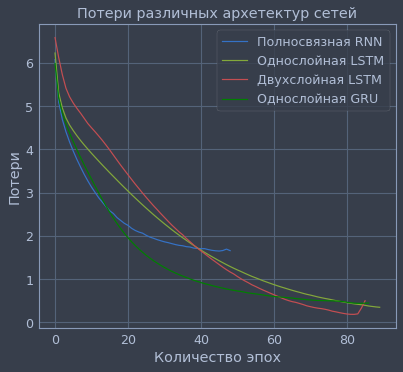

In [0]:
plt.plot(simple_rnn_hist.history['loss'])
plt.plot(single_lstm_hist.history['loss'])
plt.plot(double_lstm_hist.history['loss'])
plt.plot(single_gru_hist.history['loss'], color = 'green')
plt.title('Потери различных архетектур сетей')
plt.ylabel('Потери')
plt.xlabel('Количество эпох')
plt.legend(['Полносвязная RNN', 'Однослойная LSTM', 'Двухслойная LSTM', 
            'Однослойная GRU'], loc='upper right')
plt.show()

### Демонстрация работы

#### Подготовка модели

Полученные нами модели построены для обучения на пакетах размера **BATCH_SIZE**, однако при генерации текста мы отправляем в модель одну последовательность произвольного размера. Поэтому перестроим наши модели для еденичного размера пакета и загрузим в них веса обученных моделей из контрольных точек. 

In [0]:
checkpoint_dir = os.path.join(RNN_DIR, "checkpoints/")

simple_rnn = ModelRNN(w2v, 1, UNITS, NEUROS, RATE)
simple_rnn.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
simple_rnn.build(tf.TensorShape([1, None]))

In [0]:
checkpoint_dir = os.path.join(SINGLE_DIR, "checkpoints/")

single_lstm = ModelSingleLSTM(w2v, 1, UNITS, NEUROS, RATE)
single_lstm.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
single_lstm.build(tf.TensorShape([1, None]))

In [0]:
checkpoint_dir = os.path.join(DOUBLE_DIR, "checkpoints/")

double_lstm = ModelDoubleLSTM(w2v, 1, UNITS, NEUROS, RATE)
double_lstm.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
double_lstm.build(tf.TensorShape([1, None]))

In [0]:
checkpoint_dir = os.path.join(GRU_DIR, "checkpoints/")

single_gru = ModelGRU(w2v, 1, UNITS, NEUROS, RATE)
single_gru.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
single_gru.build(tf.TensorShape([1, None]))

Предсказанная рекуррентной моделью последовательность слов пред объединением в текст требует обработки. Простейшая функция обработки для обработки представлена здесь.

#### Сохранение моделей

Для того, что бы не обучать модели заново в будущем, сохраним их дл будущего использования.

In [0]:
filename = os.path.join(RNN_DIR, "simple_rnn.h5")
simple_rnn.save(filename)

In [0]:
filename = os.path.join(SINGLE_DIR, "single_lstm.h5")
single_lstm.save(filename)

In [0]:
filename = os.path.join(DOUBLE_DIR, "double_lstm.h5")
double_lstm.save(filename)

In [0]:
filename = os.path.join(GRU_DIR, "single_gru.h5")
single_gru.save(filename)

#### Генерация

Простейший преобразователь.

In [0]:
def list_to_text(words):
  ans = ""
  higher = False
  puncts = {".", ",", ":", "!", "?", ";", '"', "'", "’"}
  enders = {".", "?", "!"}
  for word in words:
    if higher:
      word = word.capitalize()
    if word in puncts:
      ans += word
    else:
      ans += " " + word
    
    higher = False
    if word in enders:
      higher = True
  return ans

Основная функция генерации текста. Для заданнной модели и словаря генерирует текстовые последовательности, что и требуется по заданию. 

Для генерации последовательности в функцию передается начальная строка, которая задаётся в модель для предсказания текста. Этот текст пробразуется функцией выше в читаемый вид.

In [0]:
def generate_text(model, word2idx, idx2word, start_string, num_generate=20):
  # Evaluation step (generating text using the learned model)
  # Converting our start string to numbers (vectorizing)
  seq = tokenize_text(start_string)

  converter = lambda x: word_to_int(x, word2idx)
  input_eval = list(map(converter, seq))

  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []
  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.25

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2word[predicted_id])

  return start_string + list_to_text(text_generated)

In [0]:
generate_text(simple_rnn, word2idx, idx2word, "I predict that it will be", 50)

'I predict that it will be best of the circumstantial scandal, with the new friend Mr. Grimwig. Like this, some kind looking twice routed themselves above its originator, her better effect upon the face opposite intentions in his respect habitual feeling absolutely chance to extreme seriousness, he thought: one no'

In [0]:
generate_text(single_lstm, word2idx, idx2word, "I predict that it will be", 50)

'I predict that it will be out his heart, they parted behind the FIRST him too, so the expression ( alas! I repeat Dorian Gray with closed out where can’ t know where i know how came in September Dounia’ s stifling daily in what was nothing about him. ” she'

In [0]:
generate_text(double_lstm, word2idx, idx2word, "I predict that it will be", 50)

"I predict that it will be necessary that they lie, so fond of harm, that you would do sit down his usual, i must close to her supper for Avdotya Romanovna began all, as he had rented worse. Mortimer, according to find himself. The best. 'that for the"

In [0]:
generate_text(single_gru, word2idx, idx2word, "I predict that it will be", 50)

'I predict that it will be too. She was fine day his eyes on, Vronsky felt at self-knowledge, who can promise? If anyone of his wont to ask of politics and motion, that Sviazhsky, i have something fine as well; it soon she added, the care of roses'

### Итог

В результате мы получили 4 нейронных сети с рекуррентными слоями различных архитектур и посмотрели на то, как каждая из них генерирует последовательности слов и можем оценить насколько сгенерированные последовательности похожи на те, которые производит человек. 

Перед тем, как залить репозиторий на *GitHub*, я удалю все чекпоины и файлы моделей, котрые создавал в процессе, поскольку их вес слишком велик. Если вам действительно нужны полученные модели, удалите последнюю строчку кода, которая будет приямо под этой записью.

In [1]:
rm -rf single_lstm full_rnn double_lstm single_gru

<h5> <center>Сделано Бронниковым Максимом</center> </h5>
<h5> <center>25.05.2020</center> </h5>